In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn,optim
import numpy as np
train_path = r"D:\guvi\data\emotion\train"
test_path = r"D:\guvi\data\emotion\test"
transformation = transforms.Compose (
    [
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]
)
train_data = datasets.ImageFolder(root = train_path,transform=transformation)
test_data = datasets.ImageFolder(root = test_path,transform=transformation)
train_loader = DataLoader(train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(test_data,batch_size=32,shuffle=True)

train_data

Dataset ImageFolder
    Number of datapoints: 9214
    Root location: D:\guvi\data\emotion\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

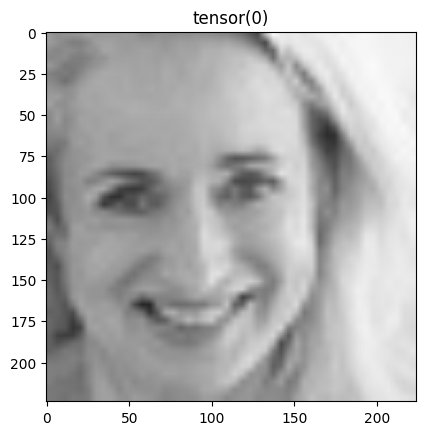

In [2]:
imgs,labels = next(iter(train_loader))
img = imgs[1]
img = img/2+0.5
img = img.numpy()
img = np.transpose(img,(1,2,0))
plt.imshow(img)
plt.title(labels[4])
plt.show()

In [3]:
import pathlib
root = pathlib.Path(train_path)
label_list =  sorted([i.name.split('/')[-1] for i in root.iterdir()])
print(label_list)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Input channels: 3, Output channels: 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling by 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # Flatten the tensor to feed into fully connected layers
            nn.Linear(128 * 28 * 28, 512),  # Adjust based on input size
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            
            nn.Linear(512, num_classes)  # Output layer
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize the model
num_classes = len(train_data.classes)  # Number of classes from the dataset
model = EmotionCNN(num_classes)

# Print model summary
# print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 1.8405


In [ ]:
# Load the model for evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Load the model for training
correct = 0
total = 0
 
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Train Accuracy: {100 * correct / total:.2f}%")

# Save the trained model
# torch.save(model.state_dict(), "emotion_cnn_model.pth")


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Initialize lists to store true labels and predicted labels
all_labels = []
all_predictions = []

model = EmotionCNN(num_classes)
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Append true labels and predictions
        all_labels.extend(labels.cpu().numpy())  # Convert tensors to numpy arrays
        all_predictions.extend(predicted.cpu().numpy())

# Calculate metrics
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
accuracy = accuracy_score(all_labels, all_predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
